<a href="https://colab.research.google.com/github/Ricardojnf33/sistema_de_recomendacao/blob/main/Sistema_de_recomendacoes_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.0. PASSO 0 - Importe das bibliotecas e dependências necessárias:

In [ ]:
from surprise import Dataset, Reader
from surprise import KNNWithMeans
from surprise.model_selection import train_test_split
from surprise import accuracy

In [ ]:
# Importar bibliotecas necessárias
import pandas as pd
from surprise import Reader, Dataset, KNNWithMeans
from sklearn.decomposition import TruncatedSVD
import numpy as np

In [56]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
!pip install inflection

In [2]:
!pip install mlxtend
!pip install scikit-surprise

import pandas as pd
import numpy as np
from surprise import KNNWithMeans, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD


from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.frequent_patterns import association_rules

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3096334 sha256=f79d449ffb9bf5ff331a7f4669c22dedadf9bd2eb97dd4919e09e5d9adb492ce
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


## 0.1. Helper Functions

In [3]:
# Renomeia as colunas de um DataFrame com novos nomes

def renomear_colunas(df):
    colunas_novas = {
        'Invoice ID': 'ID da Fatura',
        'Branch': 'Filial',
        'City': 'Cidade',
        'Customer type': 'Tipo de Cliente',
        'Gender': 'Gênero',
        'Product line': 'Linha de Produto',
        'Unit price': 'Preço Unitário',
        'Quantity': 'Quantidade',
        'Tax 5%': 'Imposto 5%',
        'Total': 'Total',
        'Date': 'Data',
        'Time': 'Hora',
        'Payment': 'Pagamento',
        'cogs': 'COGS',
        'gross margin percentage': 'Margem Bruta (%)',
        'gross income': 'Lucro Bruto',
        'Rating': 'Avaliação'
    }
    df = df.rename(columns=colunas_novas)
    return df

In [18]:
# Cria uma nova coluna "ID da Fatura 2" em um DataFrame e a move para o lado da coluna "ID da Fatura"
def criar_id_fatura_2(df):
    id_fatura_2 = []
    for i in range(len(df)):
        id_fatura_2.append(i)
    df["ID da Fatura 2"] = id_fatura_2
    df.insert(1, "ID da Fatura 2", df.pop("ID da Fatura 2"))
    return df

In [4]:
# Cria uma nova coluna "ID da Fatura 2" em um DataFrame e a move para o lado da
# coluna "ID da Fatura"

def criar_id_fatura_2(df):
    id_fatura_2 = []
    for i in range(len(df)):
        id_fatura_2.append(i + 1)
    df["ID da Fatura 2"] = id_fatura_2
    df.insert(1, "ID da Fatura 2", df.pop("ID da Fatura 2"))
    return df

# Clonando o repositório do github

In [5]:
!git clone https://github.com/Ricardojnf33/sistema_de_recomendacao.git

Cloning into 'sistema_de_recomendacao'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), 105.91 KiB | 2.46 MiB/s, done.


## Carregando o conjunto de dados de exemplo do Kaggle (Groceries Market Basket Dataset) link [ https://www.kaggle.com/datasets/irfanasrullah/groceries ] depositados em repositorio no github.

# Método apriori DO EXEMPLO do vídeo que tu mandou.

In [3]:
df = pd.read_csv('/content/sistema_de_recomendacao/compras.csv', header=None)
df.replace(np.nan, 0, inplace = True)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,citrus fruit,semi-finished bread,margarine,ready soups,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tropical fruit,yogurt,coffee,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,whole milk,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pip fruit,yogurt,cream cheese,meat spreads,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,other vegetables,whole milk,condensed milk,long life bakery product,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Função para remover todas as ocorrências de um valor em uma lista

In [4]:
def removeAllOcurrencesOfValueInList(_list, value):
    return list(filter(lambda x: x != value, _list))

### Obter uma lista de listas, cada uma representando uma transação no dataset

In [5]:
list_all_transactions = []

for index, row in df.iterrows():
    list_single_transaction = row.values.tolist()
    list_single_transaction = removeAllOcurrencesOfValueInList(list_single_transaction, 0)
    list_all_transactions.append(list_single_transaction)

#10 primeiras transações
print(list_all_transactions[0:10])

[['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'], ['tropical fruit', 'yogurt', 'coffee'], ['whole milk'], ['pip fruit', 'yogurt', 'cream cheese', 'meat spreads'], ['other vegetables', 'whole milk', 'condensed milk', 'long life bakery product'], ['whole milk', 'butter', 'yogurt', 'rice', 'abrasive cleaner'], ['rolls/buns'], ['other vegetables', 'UHT-milk', 'rolls/buns', 'bottled beer', 'liquor (appetizer)'], ['potted plants'], ['whole milk', 'cereals']]


### Codificação das listas de transações usando One Hot Encoding

In [6]:
te = TransactionEncoder()
#http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/
te_ary = te.fit(list_all_transactions).transform(list_all_transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

df.head()

,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,baby food,bags,baking powder,bathroom cleaner,beef,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


### Aplicação do algoritmo Apriori para encontrar os conjuntos frequentes

In [7]:
frequent_itemsets = apriori(df, min_support = 0.01, use_colnames = True)
frequent_itemsets.sort_values(by=['support'], ascending = False).head(10)

,support,itemsets
86,0.255516,(whole milk)
55,0.193493,(other vegetables)
66,0.183935,(rolls/buns)
75,0.174377,(soda)
87,0.139502,(yogurt)
6,0.110524,(bottled water)
67,0.108998,(root vegetables)
81,0.104931,(tropical fruit)
73,0.098526,(shopping bags)
70,0.093950,(sausage)


### Aplicação das regras de associação aos conjuntos frequentes

In [8]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
rules.sort_values(by=['lift'], ascending = False).drop(['antecedent support', 'consequent support', 'leverage', 'conviction'], axis=1)

,antecedents,consequents,support,confidence,lift
73,"(other vegetables, citrus fruit)",(root vegetables),0.010371,0.359155,3.295045
95,"(tropical fruit, other vegetables)",(root vegetables),0.012303,0.342776,3.144780
1,(beef),(root vegetables),0.017387,0.331395,3.040367
74,"(citrus fruit, root vegetables)",(other vegetables),0.010371,0.586207,3.029608
96,"(tropical fruit, root vegetables)",(other vegetables),0.012303,0.584541,3.020999
...,...,...,...,...,...
65,(waffles),(whole milk),0.012710,0.330688,1.294196
17,(coffee),(whole milk),0.018709,0.322242,1.261141
61,(sausage),(whole milk),0.029893,0.318182,1.245252
6,(bottled water),(whole milk),0.034367,0.310948,1.216940


# Análise exploratória de dataset Kaggle Link: https://www.kaggle.com/datasets/aungpyaeap/supermarket-sales

# AED + Visualização +6 ML models

In [6]:
# Carregando o conjunto de dados de exemplo do Kaggle (Groceries Market Basket Dataset) do repositório no GitHub
df = pd.read_csv('/content/sistema_de_recomendacao/supermarket_sales.csv').reset_index(drop=True)


## 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [7]:
df1 = df.copy()

In [ ]:
df3 = df.copy()

In [8]:
df1.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [9]:
# Descrição dos dados
descricao = df1.describe(include='all')

print("Descrição dos dados:")
print(descricao)

Descrição dos dados:
         Invoice ID Branch    City Customer type  Gender         Product line  \
count          1000   1000    1000          1000    1000                 1000   
unique         1000      3       3             2       2                    6   
top     750-67-8428      A  Yangon        Member  Female  Fashion accessories   
freq              1    340     340           501     501                  178   
mean            NaN    NaN     NaN           NaN     NaN                  NaN   
std             NaN    NaN     NaN           NaN     NaN                  NaN   
min             NaN    NaN     NaN           NaN     NaN                  NaN   
25%             NaN    NaN     NaN           NaN     NaN                  NaN   
50%             NaN    NaN     NaN           NaN     NaN                  NaN   
75%             NaN    NaN     NaN           NaN     NaN                  NaN   
max             NaN    NaN     NaN           NaN     NaN                  NaN   

      

### 1.1. Renomear Colunas

In [12]:
# Rename Columns
df1 = renomear_colunas(df1)

### 1.2. Dimensões dos Dados

In [13]:
print("1.2. Dimensões dos Dados:")
print("Número de linhas:", df1.shape[0])
print("Número de colunas:", df1.shape[1])
print()

1.2. Dimensões dos Dados:
Número de linhas: 1000
Número de colunas: 17



### 1.3. Tipos Dados

In [14]:
print("1.3. Tipos de Dados:")
print(df1.dtypes)
print()

1.3. Tipos de Dados:
ID da Fatura         object
Filial               object
Cidade               object
Tipo de Cliente      object
Gênero               object
Linha de Produto     object
Preço Unitário      float64
Quantidade            int64
Imposto 5%          float64
Total               float64
Data                 object
Hora                 object
Pagamento            object
COGS                float64
Margem Bruta (%)    float64
Lucro Bruto         float64
Avaliação           float64
dtype: object



### 1.4. Check NAN's

In [15]:
print("1.4. Valores Ausentes:")
print(df1.isna().sum())

1.4. Valores Ausentes:
ID da Fatura        0
Filial              0
Cidade              0
Tipo de Cliente     0
Gênero              0
Linha de Produto    0
Preço Unitário      0
Quantidade          0
Imposto 5%          0
Total               0
Data                0
Hora                0
Pagamento           0
COGS                0
Margem Bruta (%)    0
Lucro Bruto         0
Avaliação           0
dtype: int64


In [19]:
df1 = criar_id_fatura_2(df1)
print(df1.head())

  ID da Fatura  ID da Fatura 2 Filial     Cidade Tipo de Cliente  Gênero  \
0  750-67-8428               0      A     Yangon          Member  Female   
1  226-31-3081               1      C  Naypyitaw          Normal  Female   
2  631-41-3108               2      A     Yangon          Normal    Male   
3  123-19-1176               3      A     Yangon          Member    Male   
4  373-73-7910               4      A     Yangon          Normal    Male   

         Linha de Produto  Preço Unitário  Quantidade  Imposto 5%     Total  \
0       Health and beauty           74.69           7     26.1415  548.9715   
1  Electronic accessories           15.28           5      3.8200   80.2200   
2      Home and lifestyle           46.33           7     16.2155  340.5255   
3       Health and beauty           58.22           8     23.2880  489.0480   
4       Sports and travel           86.31           7     30.2085  634.3785   

        Data   Hora    Pagamento    COGS  Margem Bruta (%)  Lucro Br

In [20]:
df1

,ID da Fatura,ID da Fatura 2,Filial,Cidade,Tipo de Cliente,Gênero,Linha de Produto,Preço Unitário,Quantidade,Imposto 5%,Total,Data,Hora,Pagamento,COGS,Margem Bruta (%),Lucro Bruto,Avaliação
0,750-67-8428,0,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,1,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,2,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,3,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,4,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,995,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,1/29/2019,13:46,Ewallet,40.35,4.761905,2.0175,6.2
996,303-96-2227,996,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.6900,1022.4900,3/2/2019,17:16,Ewallet,973.80,4.761905,48.6900,4.4
997,727-02-1313,997,A,Yangon,Member,Male,Food and beverages,31.84,1,1.5920,33.4320,2/9/2019,13:22,Cash,31.84,4.761905,1.5920,7.7
998,347-56-2442,998,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.2910,69.1110,2/22/2019,15:33,Cash,65.82,4.761905,3.2910,4.1


## 2.0. PASSO 02 - Análise exploratória de dados

### 2.1 Realizar análise univariada

#### 2.1.1 Verificando a distribuição

Essa função analisa a distribuição de quatro variáveis em um DataFrame e plota um histograma e um gráfico Q-Q para cada uma delas. Aqui está uma explicação detalhada dos resultados de saída:

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Preço Unitário: mu = 55.67, sigma = 26.48
Preço Unitário: Skewness: 0.01
Preço Unitário: Kurtosis: -1.22


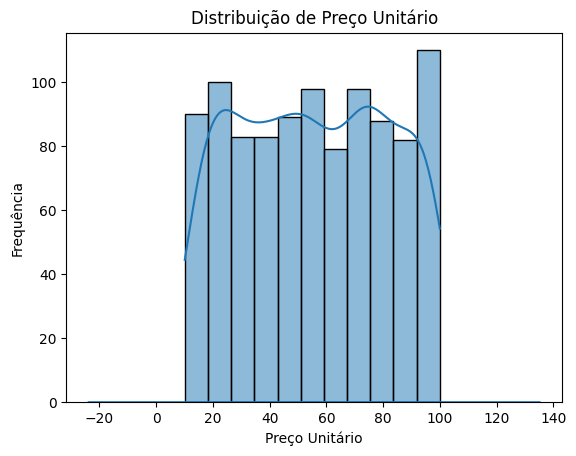

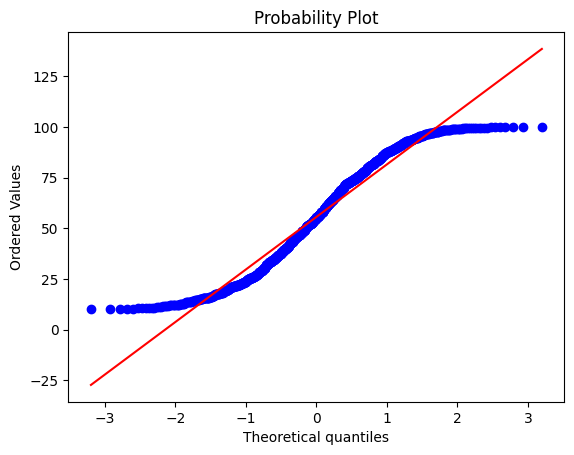

Total: mu = 322.97, sigma = 245.76
Total: Skewness: 0.89
Total: Kurtosis: -0.08


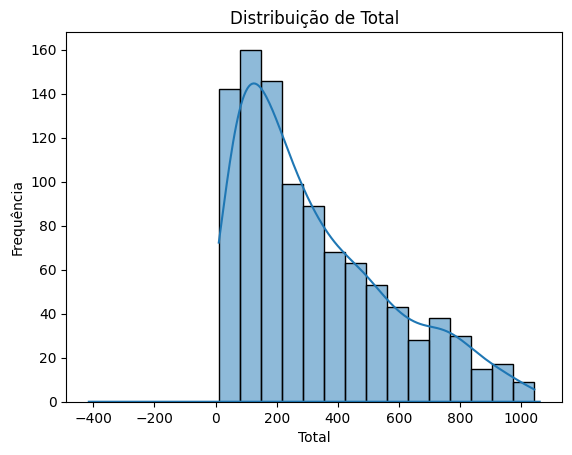

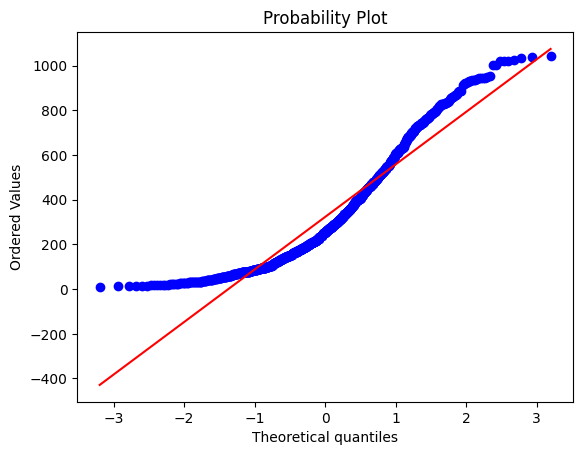

Avaliação: mu = 6.97, sigma = 1.72
Avaliação: Skewness: 0.01
Avaliação: Kurtosis: -1.15


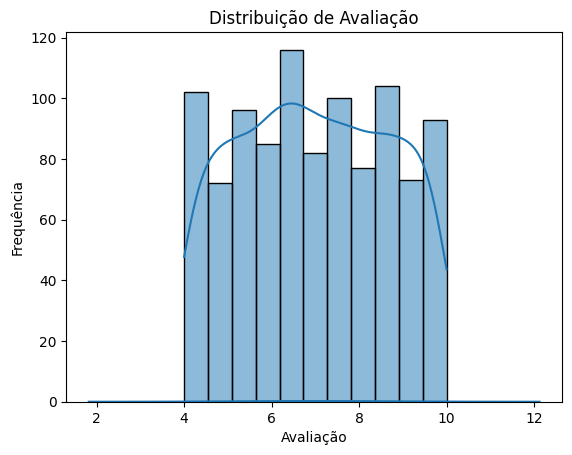

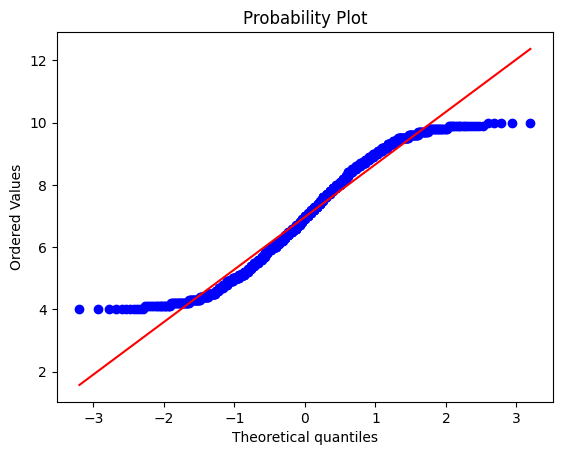

Lucro Bruto: mu = 15.38, sigma = 11.70
Lucro Bruto: Skewness: 0.89
Lucro Bruto: Kurtosis: -0.08


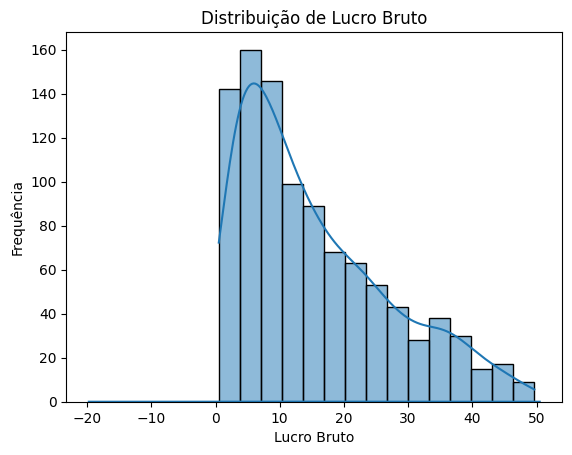

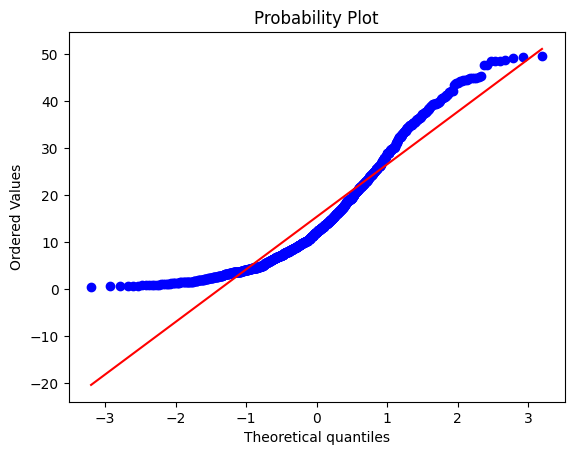

In [23]:
# Crie uma lista das colunas a serem analisadas
columns = ['Preço Unitário', 'Total', 'Avaliação', 'Lucro Bruto']

# Percorra as colunas e plote a distribuição de cada variável
for col in columns:
    # Plote a distribuição dos dados
    sns.histplot(df1[col], kde=True)

    # Ajuste uma distribuição normal aos dados
    (mu, sigma) = stats.norm.fit(df1[col])
    print('{}: mu = {:.2f}, sigma = {:.2f}'.format(col, mu, sigma))

    # Calcule a (skewness)assimetria e a (kurtosis) curtose dos dados
    print('{}: Skewness: {:.2f}'.format(col, df1[col].skew()))
    print('{}: Kurtosis: {:.2f}'.format(col, df1[col].kurt()))

    # Adicione a distribuição normal ajustada ao gráfico
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    plt.plot(x, y, label='Normal fit')

    # Adicionando rótulos e título ao gráfico
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.title('Distribuição de {}'.format(col))

    # Plote o gráfico Q-Q.
    fig = plt.figure()
    stats.probplot(df1[col], plot=plt)

    plt.show()



*   Para a variável “Preço Unitário”, a média é de 55,67 e o desvio padrão é de 26,48. A distribuição é quase simétrica com uma assimetria de 0,01 e uma curtose de -1,22. A curtose negativa indica que a distribuição é mais achatada do que uma distribuição normal. A assimetria próxima de zero indica que a distribuição é quase simétrica.
*   Para a variável “Total”, a média é de 322,97 e o desvio padrão é de 245,76. A distribuição é assimétrica à direita com uma assimetria de 0,89 e uma curtose de -0,08. A curtose próxima de zero indica que a distribuição tem um pico próximo ao centro. A assimetria positiva indica que a cauda da distribuição se estende mais para a direita do que para a esquerda.
*   Para a variável “Avaliação”, a média é de 6,97 e o desvio padrão é de 1,72. A distribuição é quase simétrica com uma assimetria de 0,01 e uma curtose de -1,15. A curtose negativa indica que a distribuição é mais achatada do que uma distribuição normal. A assimetria próxima de zero indica que a distribuição é quase simétrica.
*   Para a variável “Lucro Bruto”, a média é de 15,38 e o desvio padrão é de 11,70. A distribuição é assimétrica à direita com uma assimetria de 0,89 e uma curtose de -0,08. A curtose próxima de zero indica que a distribuição tem um pico próximo ao centro. A assimetria positiva indica que a cauda da distribuição se estende mais para a direita do que para a esquerda.




### 2.1.2 Gráfico de Distribuição de Preço Unitário

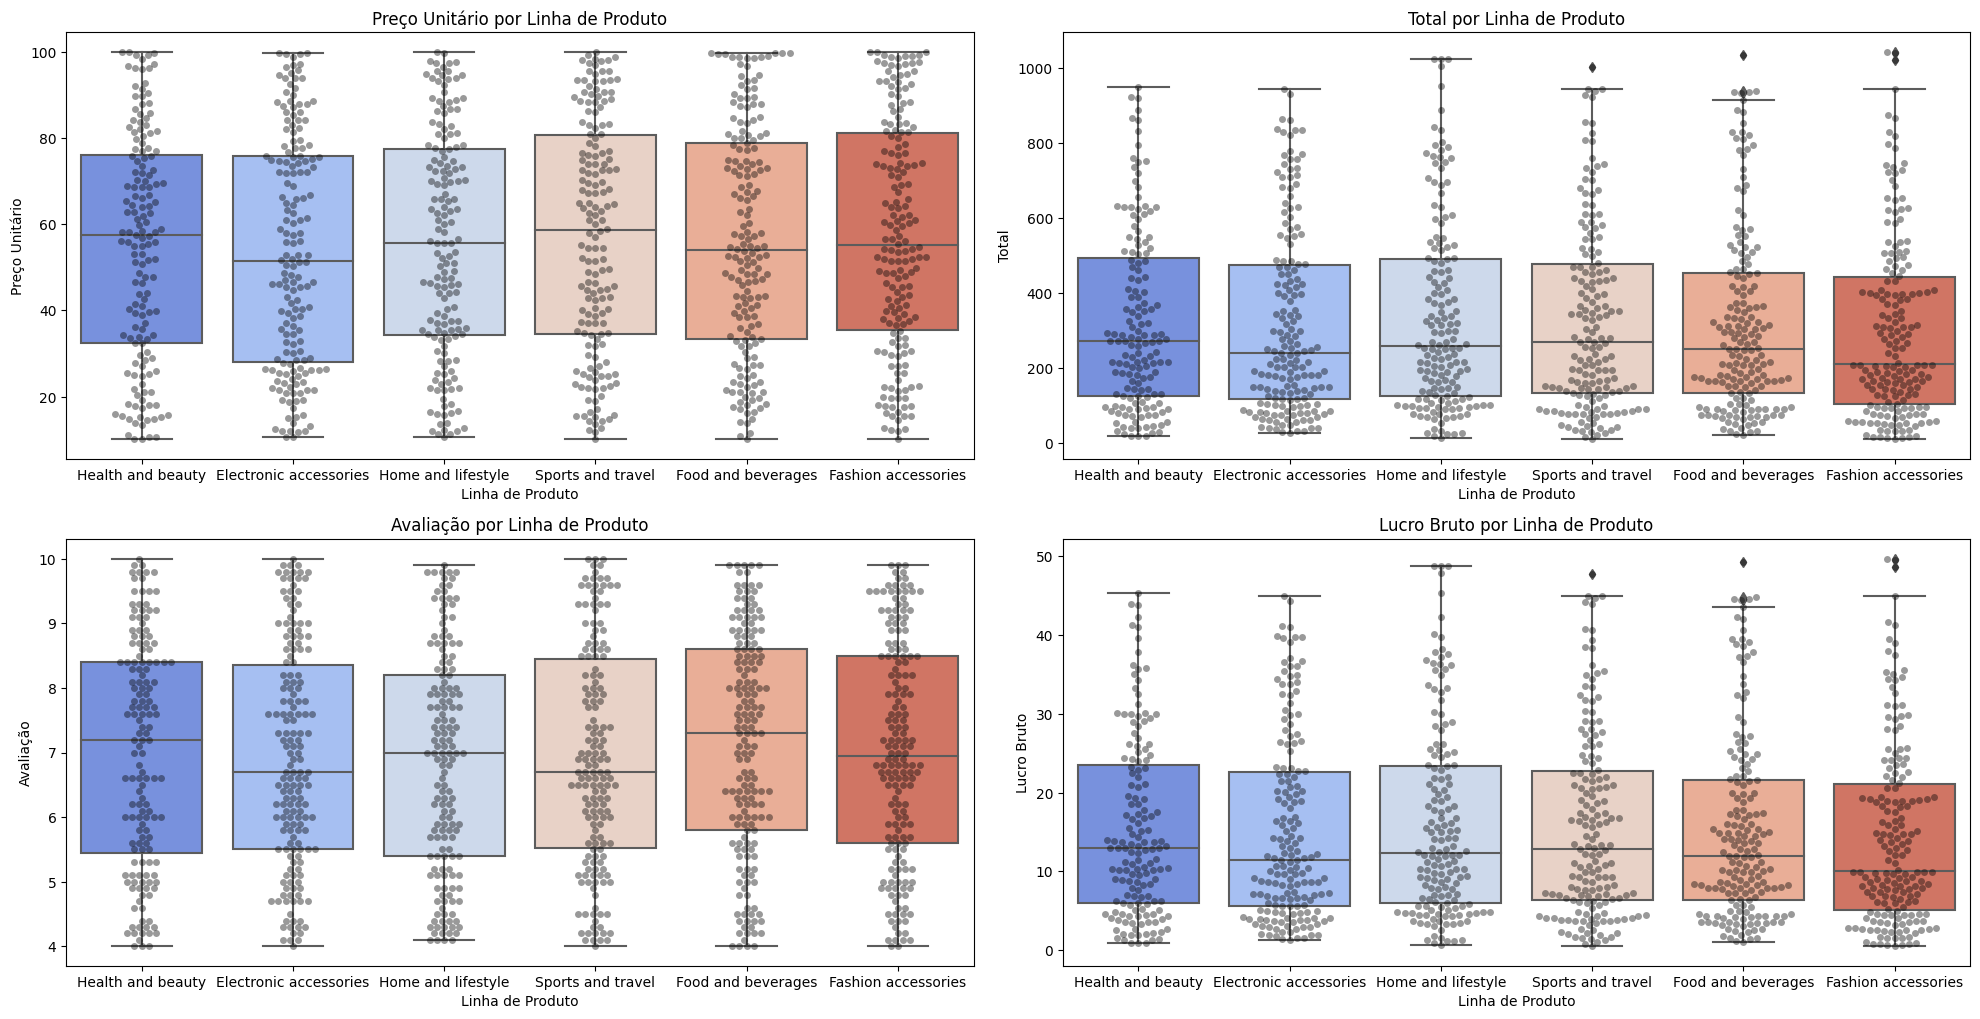

In [57]:
# Crie uma lista das colunas a serem analisadas.
columns = ['Preço Unitário', 'Total', 'Avaliação', 'Lucro Bruto']

# Crie um gráfico de caixa e um gráfico de enxame para cada coluna.
plt.figure(figsize=(20, 20))
for i, column in enumerate(columns):
    plt.subplot(len(columns), 2, i + 1)
    sns.boxplot(x='Linha de Produto', y=column, data=df1, palette='coolwarm')
    sns.swarmplot(x='Linha de Produto', y=column, data=df1, color='black', alpha=0.4)
    plt.title(f'{column} por Linha de Produto')

# Adicione rótulos e título aos gráficos.
plt.tight_layout()
plt.show()


### 2.1.3 Densidade de transações durante o horário de funcionamento

In [29]:
# Converter a coluna 'Hora' em um objeto datetime e filtre os dados para incluir apenas o horário de funcionamento da loja
df1 = df1[(df1['Hora'].dt.hour >= 10) & (df1['Hora'].dt.hour < 21)]

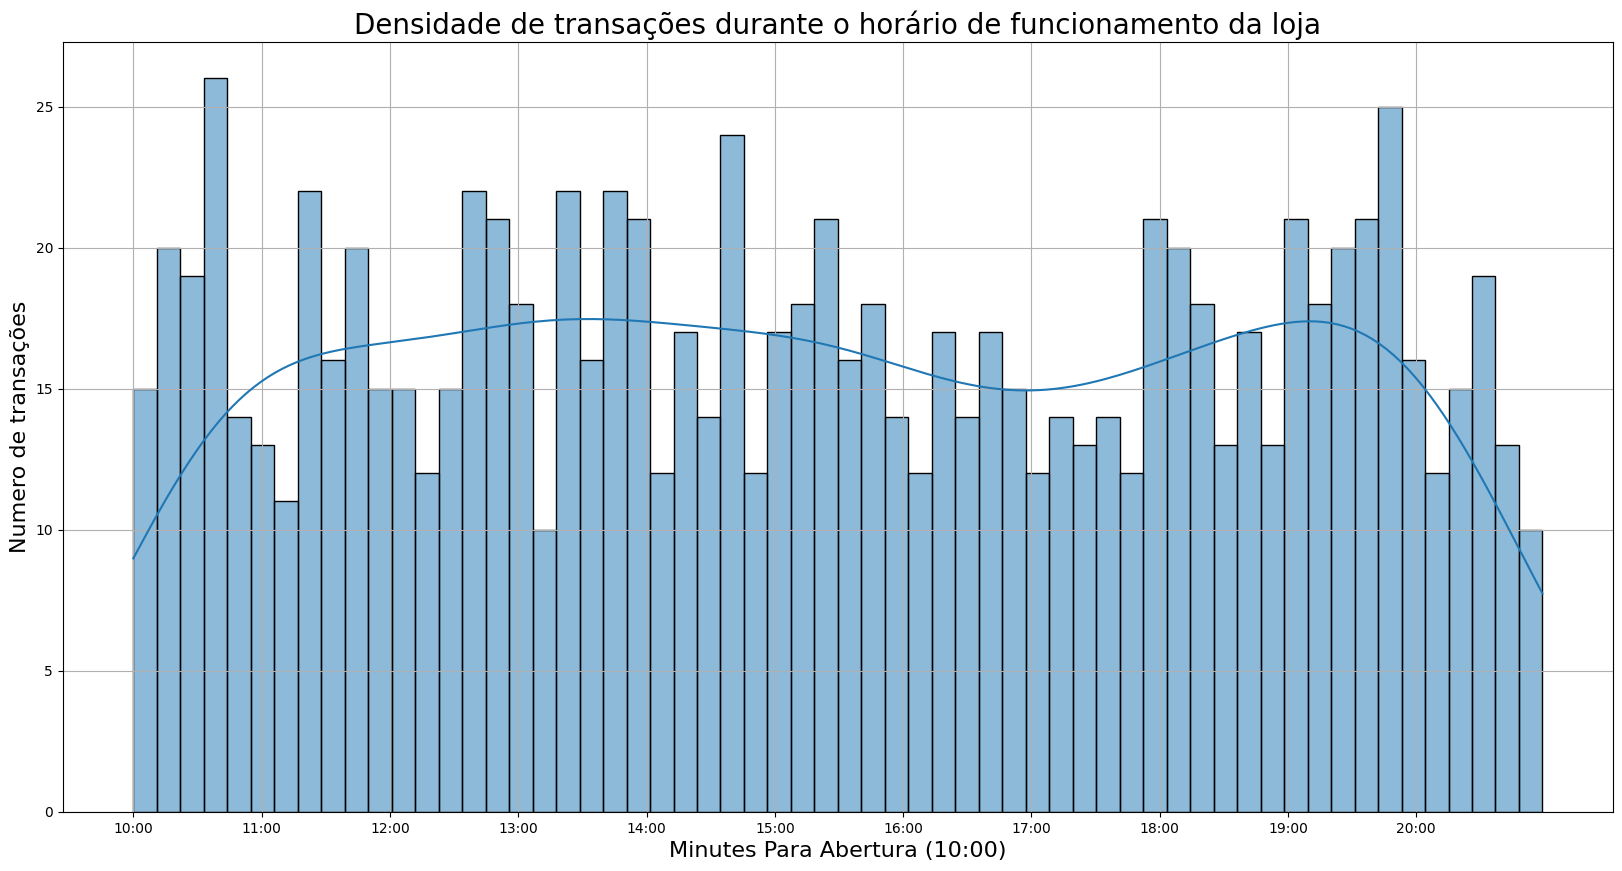

In [30]:
# Converter 'Hora' em minutos desde a abertura da loja
# Criar um gráfico de distribuição para visualizar a densidade da transação:
plt.figure(figsize=(20, 10))
sns.histplot(data=df1, x='MinutesParaAbertura', bins=60, kde=True)
plt.title('Densidade de transações durante o horário de funcionamento da loja', fontsize=20)
plt.xlabel('Minutes Para Abertura (10:00)', fontsize=16)
plt.ylabel('Numero de transações', fontsize=16)
plt.xticks(np.arange(0, 660, 60), [f"{10 + t // 60:02d}:{t % 60:02d}" for t in np.arange(0, 660, 60)])
plt.grid(True)
plt.show()

O gráfico de densidade de transações mostra a distribuição da densidade de transações ao longo do dia (das 10h00 às 21h00), com um pico na densidade de transações ocorrendo logo após a abertura da loja e uma diminuição na densidade à medida que o dia avança. Essas informações podem ser úteis para entender os padrões de tráfego da loja e tomar decisões sobre pessoal e gerenciamento de estoque.

### 2.1.4 Verificar Distribuição

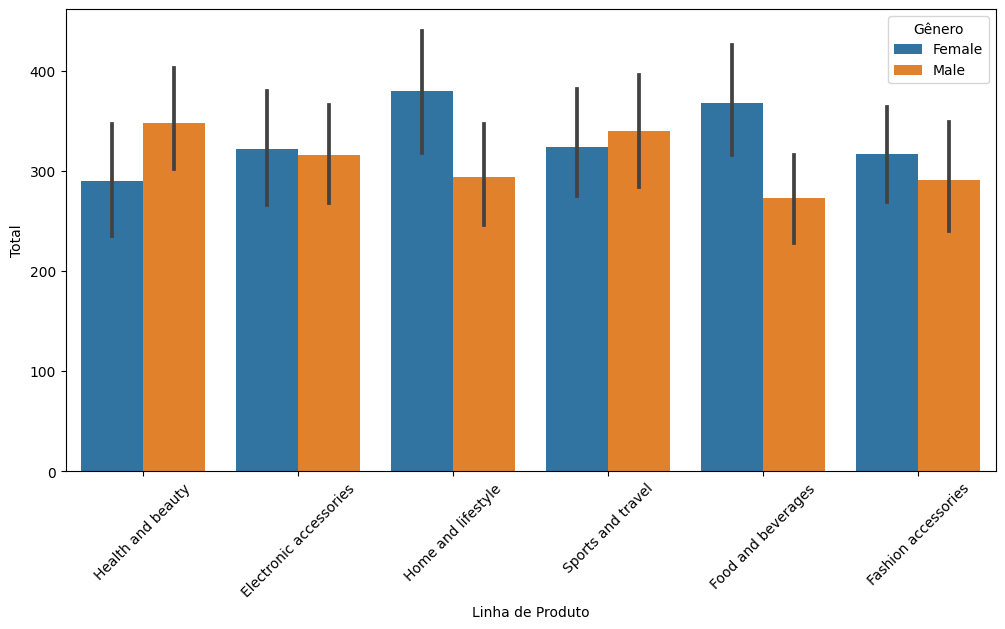

In [31]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Linha de Produto', y='Total', hue='Gênero', data=df1)
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


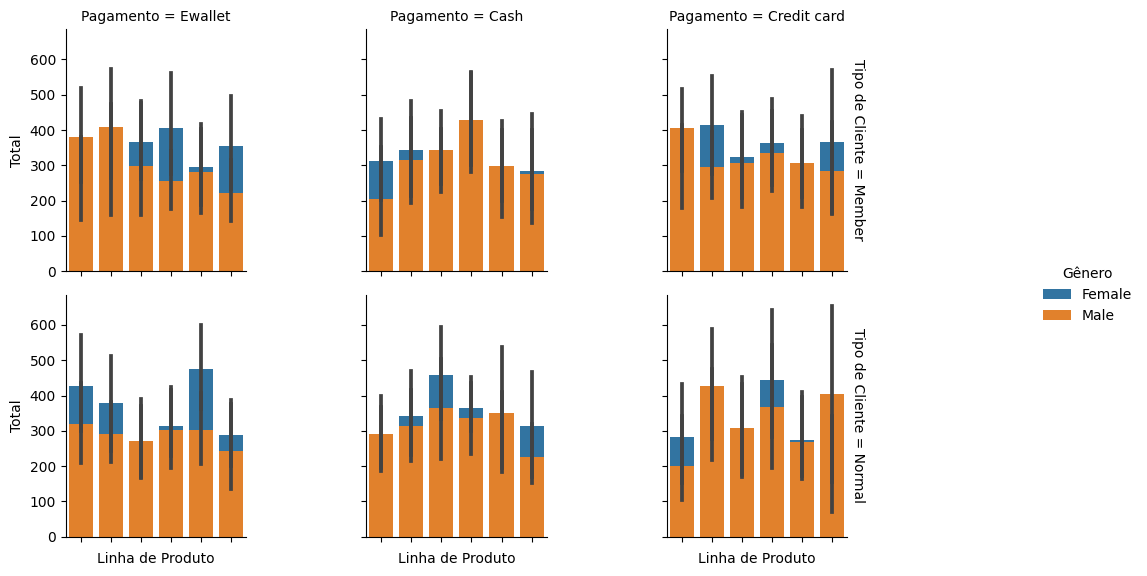

In [32]:
# Crie um objeto FacetGrid com as colunas “Pagamento” e as linhas “Tipo de Cliente”
g = sns.FacetGrid(df1, col='Pagamento', row='Tipo de Cliente', hue='Gênero', margin_titles=True)

# Plote um gráfico de barras para a coluna “Linha de Produto” e a variável “Total”
g.map(sns.barplot, 'Linha de Produto', 'Total')

# Adicione uma legenda personalizada ao gráfico
g.add_legend(title='Gênero', bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0)

# Melhore a legibilidade dos rótulos da linha de produto.
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)

plt.show()

O gráfico resultante mostra uma série de gráficos de barras, cada um correspondendo a uma combinação de 'Pagamento', 'Tipo de cliente' e 'Gênero'. Os gráficos de barras mostram o total de vendas de cada linha de produto e as cores das barras indicam o sexo dos clientes. Esse gráfico nos permite identificar rapidamente quaisquer padrões ou tendências nas vendas com base nas diferentes categorias e pode ser útil para tomar decisões informadas sobre marketing, gerenciamento de estoque e pessoal.

### 2.1.5 Vendas semanais por lote da cidade

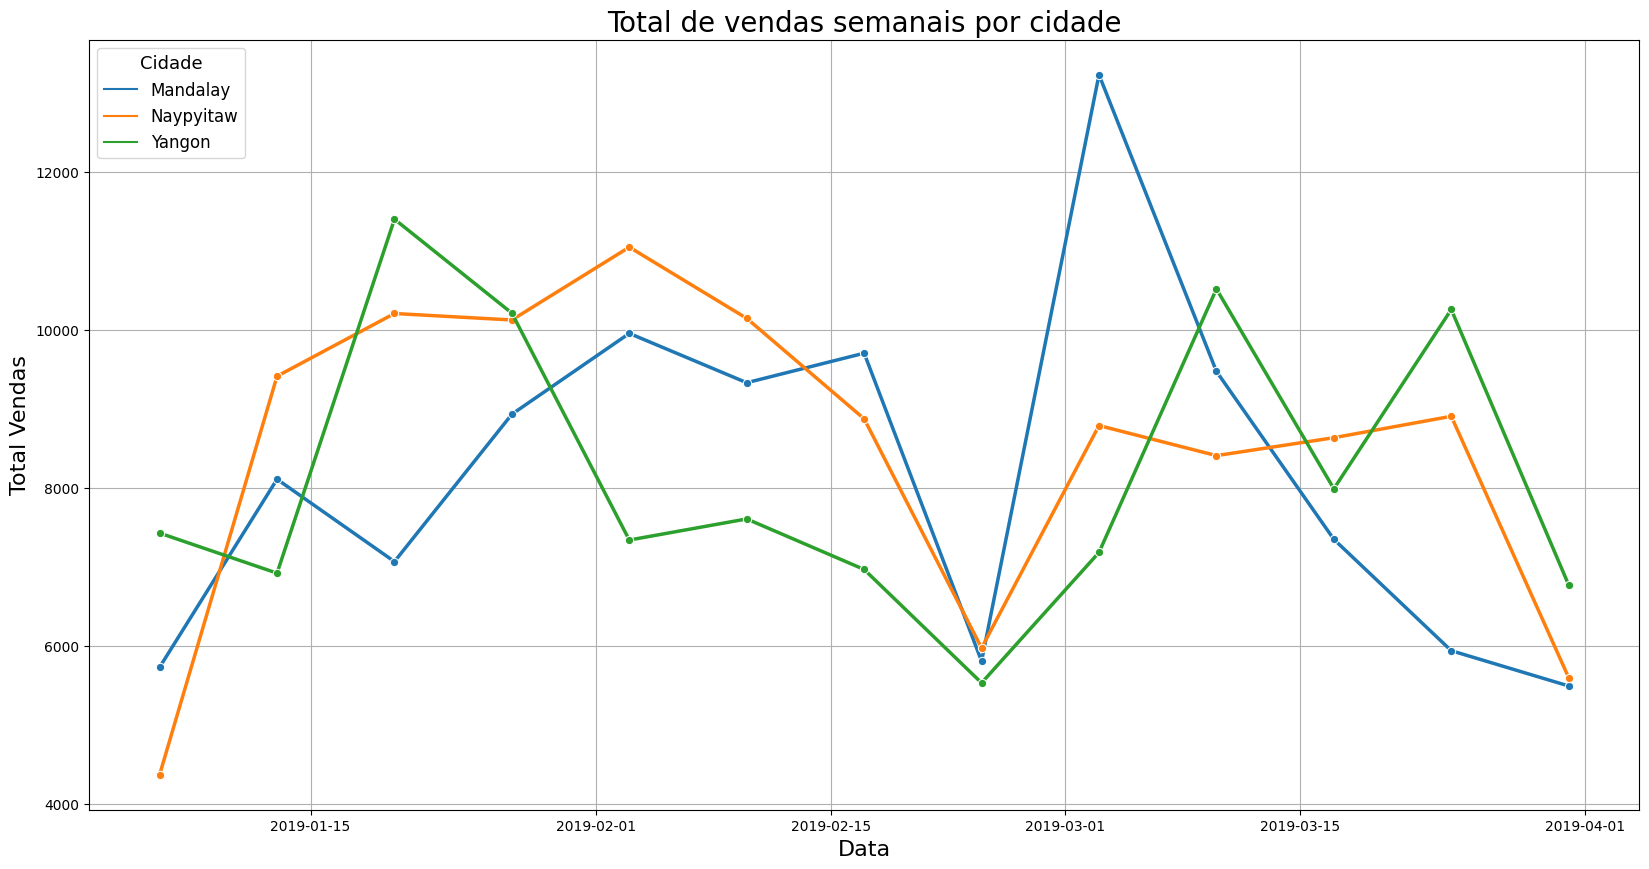

In [33]:
# Reamostrar (Resample) os dados para mostrar as vendas totais semanais

# Converta a coluna "Data" para o tipo de dados datetime.
df1['Data'] = pd.to_datetime(df1['Data'])

# Agrupe os dados por cidade e por semana e calcule as vendas totais.
weekly_data = df1.groupby(['Cidade', pd.Grouper(key='Data', freq='W')])['Total'].sum().reset_index()

# Calcule a média das vendas totais semanais.
mean_total_sales = weekly_data.groupby('Data')['Total'].mean().reset_index()
mean_total_sales.rename(columns={'Total': 'Média Total Vendas'}, inplace=True)

# Plote um gráfico de linha para as vendas totais semanais por cidade.
plt.figure(figsize=(20, 10))
sns.lineplot(x='Data', y='Total', hue='Cidade', data=weekly_data, marker='o', linewidth=2.5)

# Adicione rótulos e título ao gráfico.
plt.title('Total de vendas semanais por cidade', fontsize=20)
plt.xlabel('Data', fontsize=16)
plt.ylabel('Total Vendas', fontsize=16)
plt.grid(True)
plt.legend(title='Cidade', title_fontsize='13', loc='upper left', fontsize='12')
plt.show()


O gráfico de vendas totais semanais nos ajuda a identificar quaisquer tendências ou padrões nos dados de vendas. Por exemplo, se observarmos uma tendência de aumento nas vendas ao longo do tempo para uma determinada cidade, podemos querer investigar por que isso está acontecendo e tentar lucrar com isso. Por outro lado, se observarmos uma tendência de queda nas vendas ao longo do tempo, podemos investigar o que está causando isso e tentar fazer alterações para melhorar as vendas.

### 2.1.6 Comparação de vendas entre filiais Lote

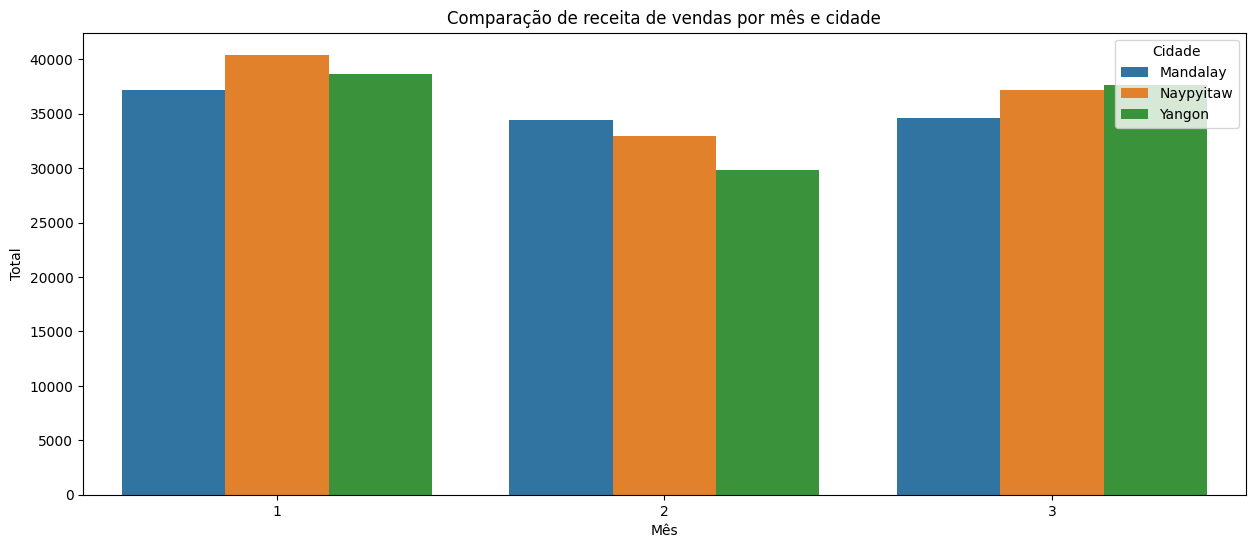

In [34]:
# Crie uma nova coluna "Mês" com o mês correspondente a cada data.
df1['Mês'] = df1['Data'].dt.month

# Agrupe os dados por cidade e mês e calcule as vendas totais.
grouped_df1 = df1.groupby(['Cidade', 'Mês'])['Total'].sum().reset_index()

# Plote um gráfico de barras para comparar a receita de vendas por mês e cidade.
plt.figure(figsize=(15, 6))
sns.barplot(x='Mês', y='Total', hue='Cidade', data=grouped_df1)

# Adicione rótulos e título ao gráfico.
plt.title('Comparação de receita de vendas por mês e cidade')
plt.xlabel('Mês')
plt.ylabel('Total')
plt.legend(title='Cidade', loc='upper right')
plt.show()


## 3.0. PASSO 3 - Efetuando Predição

Nessa análise, busquei prever a variável 'Classificação' usando o conjunto de dados fornecido contendo recursos como 'Cidade', 'Tipo de cliente', 'Gênero', 'Linha de produto', 'Preço unitário', 'Quantidade', 'Total ', 'Data', 'Hora', 'Pagamento' e 'Receita Bruta'. Extraímos recursos adicionais das colunas 'Data' e 'Hora', realizamos codificação one-hot para variáveis categóricas e padronizamos os dados antes de ajustar vários modelos de regressão.

In [35]:
df2 = df.copy()

In [36]:
# Renomear colunas
df2 = renomear_colunas(df2)

In [37]:
# Converter 'Data' para objeto datetime
df2['Data'] = pd.to_datetime(df2['Data'])

In [38]:
# Extrair características de data
df2['Dia_da_semana'] = df2['Data'].dt.dayofweek
df2['Dia_do_mes'] = df2['Data'].dt.day
df2['Mês'] = df2['Data'].dt.month


In [39]:
# Extrair características de horário
df2['Hora'] = pd.to_datetime(df2['Hora']).dt.hour
df2['Intervalo_temporal'] = pd.cut(df2['Hora'], bins=[0, 6, 12, 18, 24], labels=['noite', 'manhã', 'tarde', 'noite'], ordered=False)

In [40]:
# Codificar variáveis categóricas
# Codificar variáveis categóricas com one-hot encoding
df2_encoded = pd.get_dummies(df2, columns=['Cidade', 'Tipo de Cliente', 'Gênero', 'Linha de Produto', 'Intervalo_temporal'], drop_first=True, dummy_na=True)


In [41]:
df2_encoded

,ID da Fatura,Filial,Preço Unitário,Quantidade,Imposto 5%,Total,Data,Hora,Pagamento,COGS,...,Gênero_nan,Linha de Produto_Fashion accessories,Linha de Produto_Food and beverages,Linha de Produto_Health and beauty,Linha de Produto_Home and lifestyle,Linha de Produto_Sports and travel,Linha de Produto_nan,Intervalo_temporal_noite,Intervalo_temporal_tarde,Intervalo_temporal_nan
0,750-67-8428,A,74.69,7,26.1415,548.9715,2019-01-05,13,Ewallet,522.83,...,0,0,0,1,0,0,0,0,1,0
1,226-31-3081,C,15.28,5,3.8200,80.2200,2019-03-08,10,Cash,76.40,...,0,0,0,0,0,0,0,0,0,0
2,631-41-3108,A,46.33,7,16.2155,340.5255,2019-03-03,13,Credit card,324.31,...,0,0,0,0,1,0,0,0,1,0
3,123-19-1176,A,58.22,8,23.2880,489.0480,2019-01-27,20,Ewallet,465.76,...,0,0,0,1,0,0,0,1,0,0
4,373-73-7910,A,86.31,7,30.2085,634.3785,2019-02-08,10,Ewallet,604.17,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,40.35,1,2.0175,42.3675,2019-01-29,13,Ewallet,40.35,...,0,0,0,1,0,0,0,0,1,0
996,303-96-2227,B,97.38,10,48.6900,1022.4900,2019-03-02,17,Ewallet,973.80,...,0,0,0,0,1,0,0,0,1,0
997,727-02-1313,A,31.84,1,1.5920,33.4320,2019-02-09,13,Cash,31.84,...,0,0,1,0,0,0,0,0,1,0
998,347-56-2442,A,65.82,1,3.2910,69.1110,2019-02-22,15,Cash,65.82,...,0,0,0,0,1,0,0,0,1,0


In [42]:
# Remover colunas desnecessárias
df2_encoded.drop(['ID da Fatura', 'Data', 'Imposto 5%', 'Margem Bruta (%)', 'COGS'], axis=1, inplace=True)

In [43]:
# Dividir em variáveis de entrada e saída
X = df2_encoded.drop('Avaliação', axis=1)
y = df2_encoded['Avaliação']

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Dividir os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [45]:
# Verificar e remover valores não numéricos
non_numeric_columns = X_train.select_dtypes(exclude='number').columns
X_train = X_train.drop(non_numeric_columns, axis=1)
X_test = X_test.drop(non_numeric_columns, axis=1)

In [46]:
# Padronizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Os modelos usados na análise incluem Regressão Linear, Árvore de Decisão, Floresta Aleatória, Regressão de Vetor de Suporte (SVR), K-Vizinhos Mais Próximos (KNN) e Rede Neural (MLPRegressor). Avaliamos o desempenho desses modelos usando o score R2.

## 4.0. PASSO 4 - Resultados

In [47]:
from scipy import stats
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [48]:
# Comparação dos modelos

# Criando um dicionário com os modelos a serem comparados.
modelos = {
    "Regressão Linear": LinearRegression(),
    "Árvore de Decisão": DecisionTreeRegressor(),
    "Floresta Aleatória": RandomForestRegressor(),
    "SVR": SVR(),
    "KNN": KNeighborsRegressor(),
    "Rede Neural": MLPRegressor(max_iter=1000)
}

# Criando um dicionário vazio para armazenar os resultados.
results = {}

# Percorra o dicionário de modelos e ajuste cada modelo aos dados de treinamento.
for name, model in modelos.items():
    model.fit(X_train, y_train)

    # Faça previsões nos dados de teste usando cada modelo.
    y_pred = model.predict(X_test)

    # Calcule o coeficiente de determinação (R²) para cada modelo.
    r2 = r2_score(y_test, y_pred)

    # Armazene os resultados em um dicionário.
    results[name] = r2

    # Imprima o R² para cada modelo.
    print(f"{name}: {r2}")


Regressão Linear: -0.030334502232157945
Árvore de Decisão: -1.0026646701895698
Floresta Aleatória: -0.1237140472110092
SVR: -0.1625734778665151
KNN: -0.20818400546470928
Rede Neural: -0.5514651722066759


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Este código compara seis modelos de regressão diferentes e calcula o coeficiente de determinação (**R²**) para cada um deles. O **R²** é uma medida da proporção da variância na variável dependente que é previsível a partir da variável independente. Quanto mais próximo de *1* for *o* **R²**, melhor será o ajuste do modelo aos dados.

Os modelos comparados são:



*   **Regressão Linear**
*   **Árvore de Decisão**
*   **Floresta Aleatória**
*   **SVR**
*   **KNN**
*    **Rede Neural**


O código ajusta cada modelo aos dados de treinamento e faz previsões nos dados de teste. Em seguida, ele calcula o R² para cada modelo e armazena os resultados em um dicionário.

Os resultados mostram que a **Árvore de Decisão** teve o *pior* desempenho, com um **R²** de **-1.00**. Isso significa que o modelo não se ajustou bem aos dados e não é uma boa escolha para prever a variável dependente.

A **Rede Neural** teve o **segundo** pior desempenho, com um **R²** de **-0.55**. Isso pode ser devido ao fato de que o otimizador estocástico não convergiu durante o treinamento.

A **Regressão Linear** teve o ***melhor*** desempenho, com um **R²** de **-0.03**. Isso significa que este modelo se ajustou melhor aos dados do que os outros modelos testados.

A Floresta Aleatória teve um desempenho razoável, com um **R²** de **-0.12**. O **SVR** e o **KNN** tiveram desempenhos semelhantes, com **R²s** de **-0.16** e **-0.20**, respectivamente.

Em geral, a **Regressão Linear** parece ser a melhor escolha para prever a variável dependente com base nos dados fornecidos.

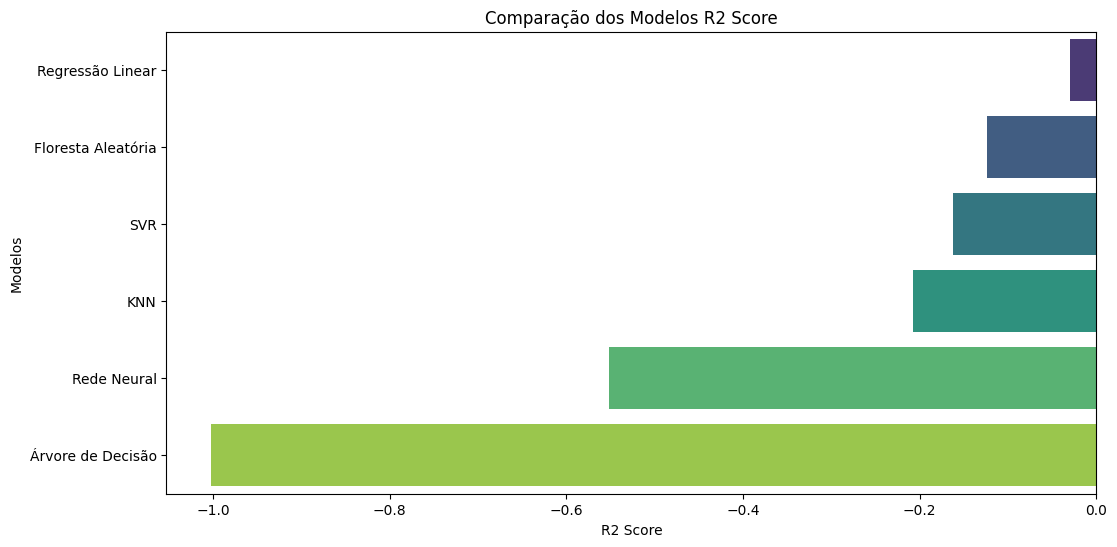

In [50]:
# Visualização

# Criando um DataFrame com os resultados dos modelos.
results_df = pd.DataFrame({"Modelos": list(results.keys()), "R2 Score": list(results.values())})

# Ordenando o DataFrame pelos valores de R² em ordem decrescente.
results_df = results_df.sort_values(by="R2 Score", ascending=False)

# Plotando um gráfico de barras para os resultados
plt.figure(figsize=(12, 6))
sns.barplot(data=results_df, x="R2 Score", y="Modelos", palette="viridis")

# Adicionando rótulos e título ao gráfico.
plt.title("Comparação dos Modelos R2 Score")
plt.xlabel("R2 Score")
plt.ylabel("Modelos")
plt.show()

## 5.0. PASSO 5 - Conclusão

Os resultados mostram que todos os modelos têm escores **R2** **negativos**, o que indica que eles são piores do que prever o valor médio da variável alvo. Isso sugere que nossa abordagem atual não é eficaz em prever a variável 'Rating'.

Pode haver várias razões para esse baixo desempenho:
Os recursos no conjunto de dados podem não ter um relacionamento forte com a variável '**Avaliação**'. Podemos precisar coletar recursos adicionais ou criar melhores interações de recursos para melhorar o desempenho do modelo.

Os hiperparâmetros padrão usados para os modelos podem não ser ideais para este conjunto de dados. Poderíamos tentar realizar o ajuste de hiperparâmetros usando métodos como GridSearchCV ou RandomizedSearchCV para encontrar o melhor conjunto de hiperparâmetros para cada modelo.

O conjunto de dados é pequeno (1.000 linhas), os modelos podem se esforçar para aprender os padrões subjacentes. Poderíamos tentar coletar mais dados ou usar técnicas como aumento de dados para aumentar o tamanho do conjunto de dados de treinamento.

Também é possível que a variável '**Avaliação**' seja inerentemente difícil de prever com base nos recursos disponíveis. Nesse caso, talvez seja necessário reconsiderar a definição do problema ou a própria variável de destino.



Dadas essas descobertas, mais investigações são necessárias para melhorar o desempenho de nossos modelos preditivos. Isso pode envolver a coleta de mais dados, a criação de melhores recursos ou a experimentação de diferentes técnicas de modelagem.

##  6.0. PASSO 6 - Sistema de Recomendações

### 6.1. Sistema de Recomendação 1

In [ ]:
# Limpeza e preparação dos dados
# (Opcional: realizar qualquer limpeza ou transformação necessária nos dados)

In [52]:
df3 = df.copy()

#### 6.1.1. Renomear colunas

In [54]:
# Renomear colunas
df3 = renomear_colunas(df3)

#### 6.1.2. Criar coluna ID da Fatura 2 correspondente a ID da Fatura (Object)

In [ ]:
df3 = criar_id_fatura_2(df3)
print(df3.head())

#### 6.1.3. Primeiro, vamos filtrar o DataFrame original, mantendo apenas os produtos que possuem mais de 50 avaliações. Isso pode ser feito da seguinte forma:

In [62]:
# Filtragem dos produtos com mais de 33 avaliações
new_df3 = df3.groupby('Linha de Produto').filter(lambda x: x['Avaliação'].count() >= 33)

#### 6.1.4. Em seguida, iremos calcular a média das avaliações para cada produto e adicionar o número de avaliações correspondente. Isso nos dará uma visão geral da média das avaliações e da quantidade de avaliações para cada produto:

In [73]:
# Cálculo da média das avaliações por produto
avaliacao_df3 = pd.DataFrame(new_df3.groupby('Linha de Produto')['Avaliação'].mean())

In [74]:
avaliacao_df3

,Avaliação
Linha de Produto,
Electronic accessories,6.924706
Fashion accessories,7.029213
Food and beverages,7.113218
Health and beauty,7.003289
Home and lifestyle,6.837500
Sports and travel,6.916265


#### 6.1.5. Adição do número de avaliações por produto


In [75]:
# Adição do número de avaliações por produto
avaliacao_df3['contagem_avaliacao'] = new_df3.groupby('Linha de Produto')['Avaliação'].count()

In [76]:
avaliacao_df3['contagem_avaliacao']

Linha de Produto
Electronic accessories    170
Fashion accessories       178
Food and beverages        174
Health and beauty         152
Home and lifestyle        160
Sports and travel         166
Name: contagem_avaliacao, dtype: int64

#### 6.1.6. Agora, vamos calcular a média global das avaliações, que chamaremos de C. Isso será usado posteriormente na fórmula de média ponderada:

In [77]:
# Cálculo da média global das avaliações
C = avaliacao_df3['Avaliação'].mean()

#### 6.1.7. Definiremos também o número mínimo de avaliações (m) para um produto ser elegível no ranking. No exemplo abaixo, vamos usar o valor mínimo de avaliações presente no DataFrame:

In [78]:
# Definição do número mínimo de avaliações para ser elegível no ranking
m = avaliacao_df3['contagem_avaliacao'].min()

#### 6.1.8. Agora, podemos definir a função weighted_rating para calcular a média ponderada de cada produto. Essa função leva em consideração o número de avaliações e a média das avaliações de cada produto:

In [79]:
# Função para calcular a média ponderada
def weighted_rating(x, m=m, C=C):
    v = x['contagem_avaliacao']
    R = x['Avaliação']
    return (v / (v + m) * R) + (m / (m + v) * C)

#### 6.1.9. Vamos aplicar essa função ao DataFrame ratings_df para calcular a pontuação de cada produto. A pontuação será adicionada como uma nova coluna chamada 'score':

In [80]:
# Adição da pontuação calculada ao DataFrame
avaliacao_df3['score'] = avaliacao_df3.apply(weighted_rating, axis=1)

#### 6.1.10. Por fim, vamos obter os produtos mais populares classificando o DataFrame ratings_df pela pontuação em ordem decrescente e selecionando os 10 primeiros produtos:

In [83]:
# Obtenção dos produtos mais populares
principais_produtos = avaliacao_df3.sort_values(by='score', ascending=False).head(10)

In [84]:
principais_produtos

,Avaliação,contagem_avaliacao,score
Linha de Produto,,,
Food and beverages,7.113218,174,7.046767
Fashion accessories,7.029213,178,7.002261
Health and beauty,7.003289,152,6.986994
Electronic accessories,6.924706,170,6.946417
Sports and travel,6.916265,166,6.942284
Home and lifestyle,6.837500,160,6.902392


### 6.2. Recomendador baseado em filtragem colaborativa (item-item)

In [95]:
# Crie um objeto Reader para especificar a escala das classificações
reader = Reader(rating_scale=(1, 10))

# Carregue os dados no formato esperado pela biblioteca Surprise
data = Dataset.load_from_df(df3[['ID da Fatura 2', 'Linha de Produto', 'Avaliação']], reader)

# Construa o conjunto de treinamento completo
trainset_full = data.build_full_trainset()

# Divida o conjunto de treinamento completo em conjunto de treinamento e teste
trainset, testset = train_test_split(trainset_full, test_size=0.3, random_state=42)

# Crie uma instância do algoritmo KNNWithMeans para o recomendador item-item
algo = KNNWithMeans(k=5, sim_options={'name': 'msd', 'user_based': False})

# Treine o modelo usando o conjunto de treinamento
algo.fit(trainset)

# Faça previsões para o conjunto de teste
predictions = algo.test(testset)

# Calcule a métrica RMSE para avaliar a precisão do modelo
accuracy.rmse(predictions)


TypeError: ignored

In [87]:
# Crie um objeto Reader para especificar a escala das classificações
reader = Reader(rating_scale=(1, 10))

# Carregue os dados no formato esperado pela biblioteca Surprise
data = Dataset.load_from_df(df3[['ID da Fatura', 'Linha de Produto', 'Avaliação']], reader)

# Divida os dados em conjunto de treinamento e teste
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

# Crie uma instância do algoritmo KNNWithMeans para o recomendador item-item
algo = KNNWithMeans(k=5, sim_options={'name': 'msd', 'user_based': False})

# Treine o modelo usando o conjunto de treinamento
algo.fit(trainset)

# Faça previsões para o conjunto de teste
predictions = algo.test(testset)

# Calcule a métrica RMSE para avaliar a precisão do modelo
accuracy.rmse(predictions)


TypeError: ignored

### 6.12. Usando o modelo para fazer recomendações para um usuário específico


In [86]:
# Substitua pelo ID do usuário específico
ID da Fatura 2 = '333'  # Substitua pelo ID do usuário específico
n_recommendations = 10

# Obtenção dos IDs dos itens semelhantes aos itens avaliados pelo usuário
item_ids = algo.get_neighbors(ID da Fatura 2, k=n_recommendations)

# Obtenção dos nomes dos produtos recomendados
recommendations = df[df3['Linha de Produto'].isin(item_ids)]['Linha de Produto'].unique()[:n_recommendations]

SyntaxError: ignored

In [ ]:
# Encontrar o índice numérico correspondente ao ID do usuário
user_index = algo.trainset.to_inner_uid(user_id)

# Verificar se o índice numérico do usuário é válido
if user_index is not None:
    # Obter os IDs dos itens semelhantes aos itens avaliados pelo usuário
    item_ids = algo.get_neighbors(user_index, k=n_recommendations)

    # Obtenção dos nomes dos produtos recomendados
    recommendations = df[df['Linha de Produto'].isin(item_ids)]['linha de Produto'].unique()[:n_recommendations]
else:
    print("O ID do usuário não foi encontrado.")



In [85]:
df3.columns

Index(['ID da Fatura', 'ID da Fatura 2', 'Filial', 'Cidade', 'Tipo de Cliente',
       'Gênero', 'Linha de Produto', 'Preço Unitário', 'Quantidade',
       'Imposto 5%', 'Total', 'Data', 'Hora', 'Pagamento', 'COGS',
       'Margem Bruta (%)', 'Lucro Bruto', 'Avaliação'],
      dtype='object')

In [ ]:
# Recomendador baseado em modelo (Matrix Factorization com SVD)

# Criação de uma matriz esparsa de avaliações
ratings_matrix = df.pivot_table(values='Avaliação', index='ID da Fatura 2', columns='Linha de Produto', fill_value=0)

# Transposição da matriz
X = ratings_matrix.T

# Redução da dimensionalidade usando Truncated SVD
svd = TruncatedSVD(n_components=10)
decomposed_matrix = svd.fit_transform(X)

# Cálculo da matriz de correlação
correlation_matrix = np.corrcoef(decomposed_matrix)

# Obtenção dos produtos similares ao produto escolhido
product_id = 'ID_DO_PRODUTO'  # Substitua pelo ID do produto específico
correlation_product_ID = correlation_matrix[X.columns == product_id]

# Obtenção das recomendações de produtos similares
similar_product_ids = X.columns[correlation_product_ID > 0.65]
recommendations = df[df['Product line'].isin(similar_product_ids)]['Product line'].unique()[:10]

# Impressão das recomendações
print(recommendations)

# Realizei uma análise exploratória de dados para entender a estrutura dos dados, como estatísticas descritivas, distribuição das avaliações, etc.

## PASSO 1 recomendador baseado em popularidade:

In [ ]:
# Crie um subconjunto de dados com produtos avaliados mais de 50 vezes
new_df = df.groupby('prod_id').filter(lambda x: x['ratings'].count() >= 50)

# Calcule a média das avaliações por produto
ratings_df = pd.DataFrame(new_df.groupby('prod_id')['ratings'].mean())

# Adicione uma coluna com o número de avaliações por produto
ratings_df['rating_counts'] = new_df.groupby('prod_id')['ratings'].count()

# Calcule a média global das avaliações
C = ratings_df['ratings'].mean()

# Defina o número mínimo de avaliações para ser elegível no ranking
m = ratings_df['rating_counts'].min()

# Função para calcular a média ponderada
def weighted_rating(x, m=m, C=C):
    v = x['rating_counts']
    R = x['ratings']
    return (v / (v + m) * R) + (m / (m + v) * C)

# Adicione a pontuação calculada ao DataFrame
ratings_df['score'] = ratings_df.apply(weighted_rating, axis=1)

# Obtenha os produtos mais populares
top_products = ratings_df.sort_values(by='score', ascending=False).head(10)


## Recomendador baseado em filtragem colaborativa (item-item):


In [ ]:
# Crie um subconjunto de dados com 70% das avaliações
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Carregue o conjunto de dados no formato esperado pelo Surprise
reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(train_df[['user_id', 'prod_id', 'ratings']], reader)

# Crie o modelo baseado em item
algo = KNNWithMeans(k=5, sim_options={'user_based': False})
algo.fit(train_data.build_full_trainset())

# Faça previsões para o conjunto de teste
predictions = algo.test(test_df[['user_id', 'prod_id', 'ratings']])

# Calcule a métrica RMSE
rmse = accuracy.rmse(predictions)


## Usando o modelo para fazer recomendações para um usuário específico:


In [ ]:
user_id = 'ID_DO_USUÁRIO'
n_recommendations = 10

# Obtenha os IDs dos itens semelhantes aos itens avaliados pelo usuário
item_ids = algo.get_neighbors(user_id, k=n_recommendations)

# Obtenha os nomes dos produtos recomendados
recommendations = df[df['prod_id'].isin(item_ids)]['prod_id'].unique()[:n_recommendations]


## Criando o recomendador baseado em modelo (Matrix Factorization com SVD):

In [ ]:
# Crie uma matriz esparsa de avaliações
ratings_matrix = df.pivot_table(values='ratings', index='user_id', columns='prod_id', fill_value=0)

# Transponha a matriz
X = ratings_matrix.T

# Reduza a dimensionalidade usando Truncated SVD
svd = TruncatedSVD(n_components=10)
decomposed_matrix = svd.fit_transform(X)

# Calcule a matriz de correlação
correlation_matrix = np.corrcoef(decomposed_matrix)

# Obtenha os produtos similares ao produto escolhido
product_id = 'ID_DO_PRODUTO'
correlation_product_ID = correlation_matrix[X.columns == product_id]

# Obtenha as recomendações de produtos similares
similar_product_ids = X.columns[correlation_product_ID > 0.65]
recommendations = df[df['prod_id'].isin(similar_product_ids)]['prod_id'].unique()[:10]


## Agora repita o passo 6 ou 7 para fazer recomendações personalizadas para outros usuários ou produtos.

In [ ]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
from surprise import KNNWithMeans, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Carregando o conjunto de dados de exemplo do Kaggle (Groceries Market Basket Dataset) do repositório no GitHub
df = pd.read_csv('https://raw.githubusercontent.com/Ricardojnf33/sistema_de_recomendacao/main/compras.csv', header=None)
df.replace(np.nan, 0, inplace=True)

# Exibindo as primeiras linhas do dataset
df.head()

# Análise Exploratória de Dados

# Crie um subconjunto de dados com produtos avaliados mais de 50 vezes
new_df = df.groupby('prod_id').filter(lambda x: x['ratings'].count() >= 50)

# Calcule a média das avaliações por produto
ratings_df = pd.DataFrame(new_df.groupby('prod_id')['ratings'].mean())

# Adicione uma coluna com o número de avaliações por produto
ratings_df['rating_counts'] = new_df.groupby('prod_id')['ratings'].count()

# Calcule a média global das avaliações
C = ratings_df['ratings'].mean()

# Defina o número mínimo de avaliações para ser elegível no ranking
m = ratings_df['rating_counts'].min()

# Função para calcular a média ponderada
def weighted_rating(x, m=m, C=C):
    v = x['rating_counts']
    R = x['ratings']
    return (v / (v + m) * R) + (m / (m + v) * C)

# Adicione a pontuação calculada ao DataFrame
ratings_df['score'] = ratings_df.apply(weighted_rating, axis=1)

# Obtenha os produtos mais populares
top_products = ratings_df.sort_values(by='score', ascending=False).head(10)

# Recomendador baseado em filtragem colaborativa (item-item)

# Crie um subconjunto de dados com 70% das avaliações
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Carregue o conjunto de dados no formato esperado pelo Surprise
reader = Reader(rating_scale=(1, 5))
train_data = Dataset.load_from_df(train_df[['user_id', 'prod_id', 'ratings']], reader)

# Crie o modelo baseado em item
algo = KNNWithMeans(k=5, sim_options={'user_based': False})
algo.fit(train_data.build_full_trainset())

# Faça previsões para o conjunto de teste
predictions = algo.test(test_df[['user_id', 'prod_id', 'ratings']])

# Calcule a métrica RMSE
rmse = accuracy.rmse(predictions)

# Usando o modelo para fazer recomendações para um usuário específico

user_id = 'ID_DO_USUÁRIO'
n_recommendations = 10

# Obtenha os IDs dos itens semelhantes aos itens avaliados pelo usuário
item_ids = algo.get_neighbors(user_id, k=n_recommendations)

# Obtenha os nomes dos produtos recomendados
recommendations = df[df['prod_id'].isin(item_ids)]['prod_id'].unique()[:n_recommendations]

# Recomendador baseado em modelo (Matrix Factorization com SVD)

# Crie uma matriz esparsa de avaliações
ratings_matrix = df.pivot_table(values='ratings', index='user_id', columns='prod_id', fill_value=0)

# Transponha a matriz
X = ratings_matrix.T

# Reduza a dimensionalidade usando Truncated SVD
svd = TruncatedSVD(n_components=10)
decomposed_matrix = svd.fit_transform(X)

# Calcule a matriz de correlação
correlation_matrix = np.corrcoef(decomposed_matrix)

# Obtenha os produtos similares ao produto escolhido
product_id = 'ID_DO_PRODUTO'
correlation_product_ID = correlation_matrix[X.columns == product_id]

# Obtenha as recomendações de produtos similares
similar_product_ids = X.columns[correlation_product_ID > 0.65]
recommendations = df[df['prod_id'].isin(similar_product_ids)]['prod_id'].unique()[:10]

# Imprima as recomendações
print(recommendations)

## Otimize os hiperparâmetros dos modelos usando técnicas como Grid Search ou Cross-Validation.

## Realize testes de robustez e sensibilidade para garantir que os modelos sejam consistentes e confiáveis.


## Implemente o sistema de recomendação em um ambiente de produção, considerando aspectos como escalabilidade e desempenho.



## Desenvolva uma interface de usuário amigável para que os usuários possam interagir com o sistema de recomendação.

## Integre o sistema de recomendação com outros componentes do produto, como bancos de dados, APIs externas, etc.

## Realize testes abrangentes do sistema de recomendação em diferentes cenários e casos de uso.

## Faça ajustes e melhorias com base nos resultados dos testes.

## Implemente recursos de monitoramento e análise de desempenho para acompanhar a eficácia e a qualidade das recomendações ao longo do tempo.

## Documente adequadamente o sistema de recomendação, incluindo todas as etapas do processo de desenvolvimento, modelos utilizados, métricas de avaliação, etc.

## Realize manutenção regular do sistema de recomendação, atualizando-o com novos dados e refinando os modelos conforme necessário.

## Esteja aberto a feedback dos usuários e ajuste o sistema de recomendação com base nas necessidades e preferências em constante evolução.



## Monitore as métricas-chave de desempenho e avalie continuamente a eficácia do sistema de recomendação.

## Faça melhorias iterativas no sistema de recomendação com base nas análises de desempenho e feedback dos usuários.

## Mantenha-se atualizado com as pesquisas e tendências mais recentes em sistemas de recomendação e incorpore novas técnicas e abordagens conforme apropriado.

## Colabore com outros profissionais, como engenheiros de software e designers, para garantir a integração adequada do sistema de recomendação no produto final.



## Realize testes de estresse e escal26. Realize testes de estresse e escalabilidade para garantir que o sistema de recomendação possa lidar com uma carga crescente de usuários e dados.

## Considere a privacidade e segurança dos dados do usuário, garantindo a conformidade com regulamentações e práticas recomendadas.

## Implemente recursos de personalização para permitir que os usuários filtrem e ajustem as recomendações de acordo com suas preferências individuais.

## Realize análises e estudos de caso para medir o impacto do sistema de recomendação no engajamento do usuário, nas vendas ou em outras métricas de negócios relevantes.

## Realize monitoramento contínuo e análise de dados para identificar padrões e tendências emergentes que possam melhorar o sistema de recomendação.

## Esteja preparado para iterar e aprimorar constantemente o sistema de recomendação à medida que novos dados e informações se tornem disponíveis.

## Meça a satisfação dos usuários por meio de pesquisas, análises de feedback e outros métodos para entender como o sistema de recomendação está atendendo às expectativas dos usuários.

## Mantenha-se atualizado com as últimas pesquisas, avanços tecnológicos e melhores práticas em sistemas de recomendação para continuar evoluindo e aprimorando seu produto final.

# Lembrando de que esses passos fornecem uma estrutura geral para desenvolver um sistema de recomendação. Os detalhes específicos podem variar dependendo do conjunto de dados, dos requisitos do produto e dos recursos disponíveis. É importante adaptar o processo de acordo com suas necessidades específicas.

